In [36]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, cross_validation
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
from sklearn.metrics import roc_curve, auc
import sklearn.tree as tree
import seaborn as sns
import graphviz 
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE, ADASYN
from statsmodels.discrete.discrete_model import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import graphviz 
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score

In [2]:
# fb_df = pd.read_csv('csv/fb_tweets_stock.csv', index_col = 0)
# netflix_df = pd.read_csv('csv/netflix_tweets_stock.csv', index_col = 0)
# apple_df = pd.read_csv('csv/apple_tweets_stock.csv', index_col = 0)

In [3]:
# fb_df['company'] = np.full((len(fb_df),1), "Facebook")
# netflix_df['company'] = np.full((len(netflix_df),1), "Netflix")
# apple_df['company'] = np.full((len(apple_df),1), "Apple")

In [4]:
# # rearranging the columns
# fb_df = fb_df[list(apple_df.columns.values)]
# missing_cols_netflix = [column for column in fb_df if column not in list(netflix_df.columns)]
# for col in missing_cols_netflix:
#     netflix_df[col] = np.nan
# # rearranging the columns
# netflix_df = netflix_df[list(apple_df.columns.values)]
# df = pd.concat([fb_df, netflix_df, apple_df], axis = 0)
# df.to_csv('fb_netflix_apple.csv')

In [5]:
df = pd.read_csv('csv/fb_netflix_apple.csv', index_col = 0)
df['company'] = df['company'].map({'Facebook': 1, 'Netflix': 2, 'Apple': 3})
df_fb = df[df['company'] ==1]
df_nf = df[df['company'] ==2]
df_ap = df[df['company'] ==3]
target = df['up_down']
X = df.loc[:, df.columns != 'up_down']
X = X.drop(['day', 'increase_decrease','movement(%)' ], axis = 1)

In [9]:
# normalize the data
def normalize(column):
    minimum = X[column].min()
    maximum = X[column].max()
    diff = maximum - minimum
    norm = (X[column] - minimum) / diff
    return norm

In [10]:
for column in list(X.columns):
    X[column] = normalize(column)
target = target.fillna(0)
X = X.fillna(0)

In [12]:
# tuning the weight using SMOTE
print(target.value_counts())
X_resampled, y_resampled = SMOTE().fit_sample(X, target) 
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

1    83
0    73
Name: up_down, dtype: int64
1    83
0    83
dtype: int64


In [13]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm,  cmap) #Create the basic matrix.
    #Add title and Axis Labels
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    class_names = set(classes) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2. #Used for text coloring below
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    plt.show()

train set accuracy: 0.782258064516129


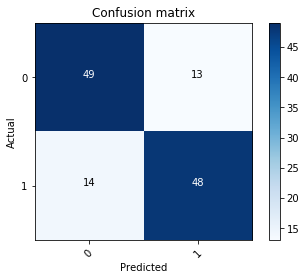

test set accuracy: 0.6190476190476191


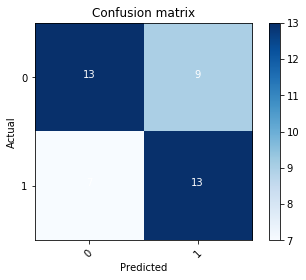

             precision    recall  f1-score   support

          0       0.65      0.59      0.62        22
          1       0.59      0.65      0.62        20

avg / total       0.62      0.62      0.62        42

0.5662650602409639
             precision    recall  f1-score   support

          0       0.61      0.56      0.59        91
          1       0.52      0.57      0.54        75

avg / total       0.57      0.57      0.57       166



In [14]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm,  cmap) #Create the basic matrix.
    #Add title and Axis Labels
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    class_names = set(classes) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2. #Used for text coloring below
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    plt.show()
    
def test_set(X, Y) :
    data_train, data_test, target_train, target_test = train_test_split(X, Y)
    logreg = LogisticRegression()
    logreg.fit(data_train, target_train)
    predict_train = logreg.predict(data_train)
    predict_test = logreg.predict(data_test)
    cnf_matrix_train = confusion_matrix(predict_train, target_train)
    cnf_matrix_test = confusion_matrix(predict_test, target_test)
    print('train set accuracy: ' + str(metrics.accuracy_score(predict_train, target_train)))
    plot_confusion_matrix(cnf_matrix_train, classes = set(y_resampled))
    print('test set accuracy: ' + str(metrics.accuracy_score(predict_test, target_test)))
    plot_confusion_matrix(cnf_matrix_test, classes = set(y_resampled))
    print(metrics.classification_report(predict_test, target_test))
    
test_set(X_resampled, y_resampled)

## cross validation
def k_fold(X, Y, cv = 3):
    predicted = cross_validation.cross_val_predict(LogisticRegression(), X, Y, cv=cv)
    print(metrics.accuracy_score(predicted.reshape((predicted.shape[0],1)), np.array(Y).reshape((Y.shape[0],1))))
    print(metrics.classification_report(predicted.reshape((predicted.shape[0],1)), np.array(Y).reshape((Y.shape[0],1))))

k_fold(X_resampled, y_resampled, cv = 10)

AUC for L1: 0.7414965986394557
AUC for L2: 0.7936507936507937


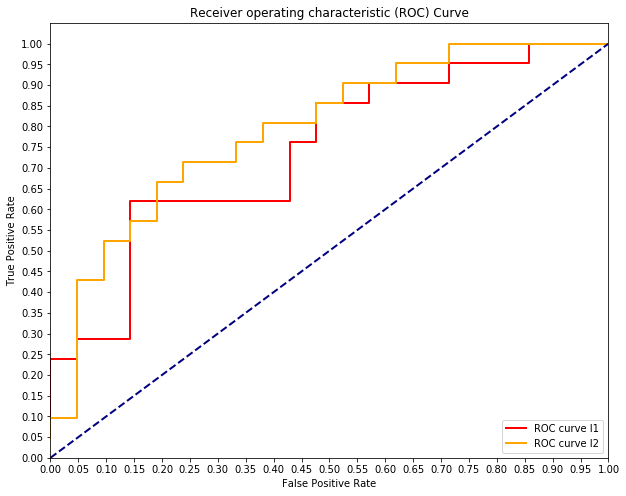

In [15]:
# LASSO Ridge
penalties = ['l1', 'l2']
colors = ['r', 'orange']

plt.figure(figsize=(10,8))

data_train, data_test, target_train, target_test = train_test_split(X_resampled, y_resampled)
area = []
for n, pen in enumerate(penalties):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = 1e12, penalty=pen) #Starter code
    model_log = logreg.fit(data_train, target_train)
#     print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(data_test)

    y_score = logreg.fit(data_train, target_train).decision_function(data_test)

    fpr, tpr, thresholds = roc_curve(target_test, y_score)
    
    print('AUC for {}: {}'.format(str(pen.upper()), auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(pen))
    area.append(auc(fpr, tpr))
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [74]:
X_tweets_new = X_tweets
X_tweets_new["total_count_30"] = X_tweets_new['coun_neg, 30'] + X_tweets_new['coun_neu, 30'] + X_tweets_new['coun_pos, 30']
X_tweets_new["total_count_60"] = X_tweets_new['coun_neg, 60'] + X_tweets_new['coun_neu, 60'] + X_tweets_new['coun_pos, 60']
X_tweets_new["total_count_120"] = X_tweets_new['coun_neg, 120'] + X_tweets_new['coun_neu, 120'] + X_tweets_new['coun_pos, 120']
X_tweets_new["total_count_night_before"] = X_tweets_new['count_neg, night_before'] + X_tweets_new['count_neu, night_before'] + X_tweets_new['count_pos, night_before']
X_tweets_new["total_count_morning"] = X_tweets_new['count_neg, morning'] + X_tweets_new['count_neu, morning'] + X_tweets_new['count_pos, morning']

X_tweets_new = X_tweets_new.drop(['coun_neg, 30', 'coun_neu, 30', 'coun_pos, 30', 'coun_neg, 60', 'coun_neu, 60', 
                                  'coun_pos, 60', 'coun_neg, 120', 'coun_neu, 120', 'coun_pos, 120', 'count_neg, night_before', 
                                  'count_neu, night_before', 'count_pos, night_before','count_neg, morning','count_neu, morning', 'count_pos, morning'], axis =1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

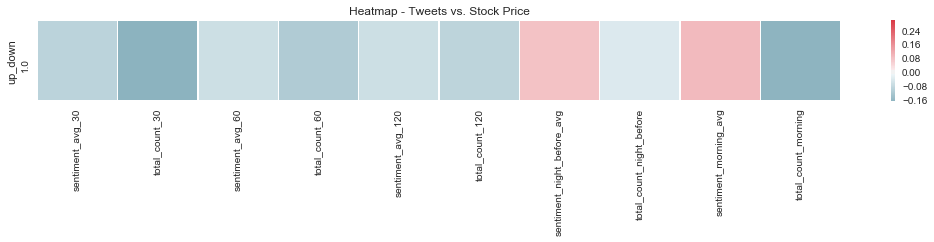

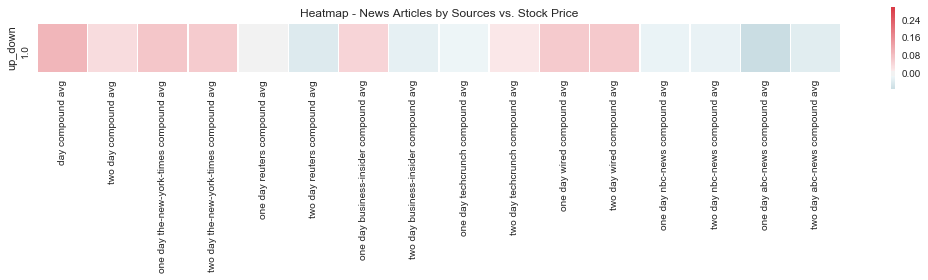

In [73]:
def correlation_heatmap(df, title = 'heatmap'):
    sns.set(style="white")
    # Compute the correlation matrix
    corr = []
    for column in list(df.columns):
        correlation = df['up_down'].corr(df[column])
        corr.append(correlation)
    corrs = pd.Series(corr).to_frame().transpose()
    corrs.columns = df.columns
    corrs = corrs.set_index('up_down')
    f, ax = plt.subplots(figsize=(18, 3))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    ax = plt.axes()
    sns.heatmap(corrs,cmap=cmap,vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
    ax.set_title(title)
    plt.show()
    
# Twitter heatmap
twitter_heatmap = pd.concat([X_tweets_new, df['up_down']], axis =1)
correlation_heatmap(twitter_heatmap, title = 'Heatmap - Tweets vs. Stock Price')

# all news heatmap
X_news = X.loc[:, 'day compound avg':]
X_news = X_news.drop(['company'], axis = 1)
news_heabtmap = pd.concat([X_news, df['up_down']], axis =1)
correlation_heatmap(news_heabtmap, title = 'Heatmap - News Articles vs. Stock Price')

compound_list = [source for source in X_news.columns if 'compound' in source]
compound_news = X_news[compound_list]
compound_news = compound_news[['day compound avg',
                         'two day compound avg',
                         'one day the-new-york-times compound avg',
                         'two day the-new-york-times compound avg',
                         'one day reuters compound avg',
                         'two day reuters compound avg',
                         'one day business-insider compound avg',
                         'two day business-insider compound avg',
                         'one day techcrunch compound avg',
                         'two day techcrunch compound avg',
                         'one day wired compound avg',
                         'two day wired compound avg',
                         'one day nbc-news compound avg',
                         'two day nbc-news compound avg',
                         'one day abc-news compound avg',
                         'two day abc-news compound avg',
                         ]]
news_compound_heabtmap = pd.concat([compound_news, df['up_down']], axis =1)
correlation_heatmap(news_compound_heabtmap, title = 'Heatmap - News Articles by Sources vs. Stock Price')

#### Random Forest

In [17]:
stock_param = ['1. open','2. high','3. low','4. close','5. volume','MACD_Hist','MACD','MACD_Signal',
 'SlowK','SlowD','RSI','ADX','CCI','Aroon Up','Aroon Down','Real Middle Band','Real Upper Band',
 'Real Lower Band','Chaikin A/D','OBV']

tweets_param = ['sentiment_avg_30','coun_neg, 30','coun_neu, 30','coun_pos, 30','sentiment_avg_60',
 'coun_neg, 60','coun_neu, 60','coun_pos, 60','sentiment_avg_120','coun_neg, 120','coun_neu, 120',
 'coun_pos, 120','sentiment_night_before_avg','count_neg, night_before','count_neu', 'night_before',
 'count_pos, night_before','sentiment_morning_avg','count_neg, morning','count_neu, morning','count_pos, morning']

news_param = ['day compound avg','day positive avg','day negative avg','day neutral avg','two day neutral avg',
 'two day positive avg','two day negative avg','two day compound avg','two day wired compound avg',
 'two day nbc-news compound avg','two day abc-news compound avg','two day reuters compound avg','two day business-insider compound avg',
 'two day the-new-york-times compound avg','two day techcrunch compound avg','two day wired neg avg',
 'two day nbc-news neg avg','two day abc-news neg avg','two day reuters neg avg','two day business-insider neg avg',
 'two day the-new-york-times neg avg','two day techcrunch neg avg','two day wired pos avg','two day nbc-news pos avg',
 'two day abc-news pos avg','two day reuters pos avg','two day business-insider pos avg','two day the-new-york-times pos avg',
 'two day techcrunch pos avg','two day wired neu avg','two day nbc-news neu avg','two day abc-news neu avg',
 'two day reuters neu avg','two day business-insider neu avg','two day the-new-york-times neu avg',
 'two day techcrunch neu avg','one day wired compound avg','one day nbc-news compound avg','one day abc-news compound avg',
 'one day reuters compound avg','one day business-insider compound avg','one day the-new-york-times compound avg',
 'one day techcrunch compound avg','one day wired neg avg','one day nbc-news neg avg','one day abc-news neg avg',
 'one day reuters neg avg','one day business-insider neg avg','one day the-new-york-times neg avg',
 'one day techcrunch neg avg','one day wired pos avg','one day nbc-news pos avg','one day abc-news pos avg',
 'one day reuters pos avg','one day business-insider pos avg','one day the-new-york-times pos avg',
 'one day techcrunch pos avg','one day wired neu avg','one day nbc-news neu avg','one day abc-news neu avg',
 'one day reuters neu avg','one day business-insider neu avg','one day the-new-york-times neu avg','one day techcrunch neu avg']

Train Set Score: 95.97%
test set score: 66.67%

 Top 10 Features:
('CCI', 0.1399)
('RSI', 0.0459)
('5. volume', 0.0305)
('MACD', 0.0303)
('2. high', 0.0299)
('coun_pos, 60', 0.0285)
('Real Upper Band', 0.0284)
('MACD_Signal', 0.028)
('SlowD', 0.0277)
('SlowK', 0.0259)


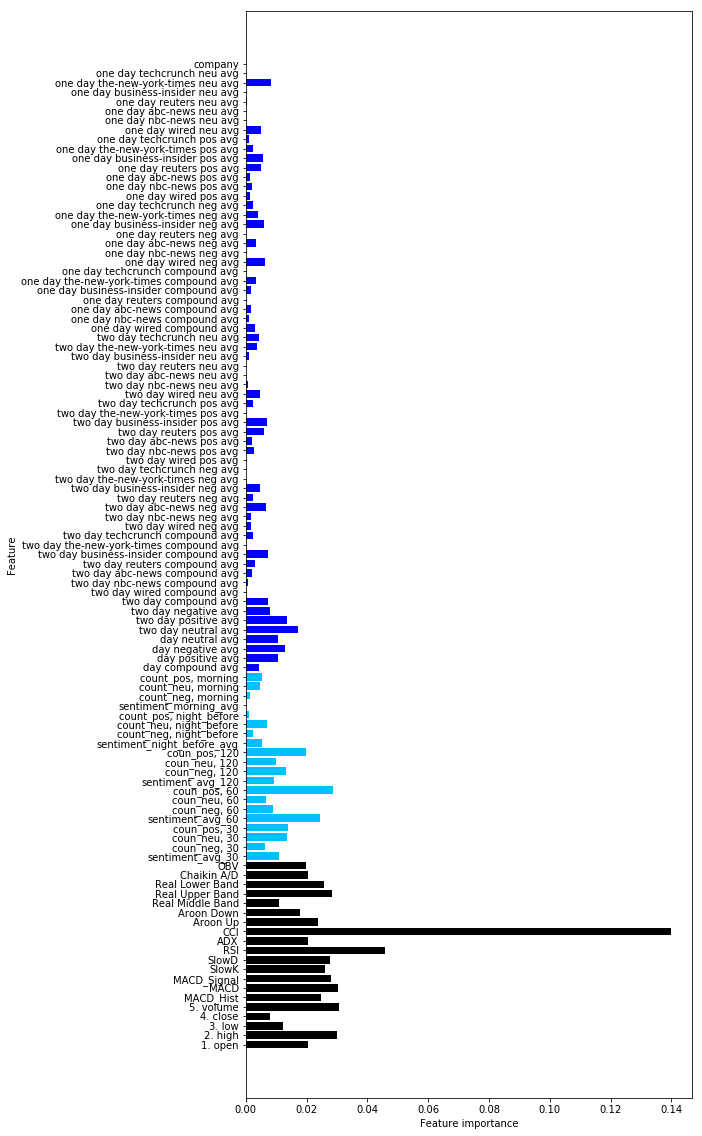

In [18]:
forest= RandomForestClassifier(n_estimators= 40, max_depth= 5)
forest.fit(data_train, target_train)
feature_importances = forest.feature_importances_
feature_importance_list = [round(value, 4) for value in feature_importances]

def plot_feature_importances(model, data):
    n_features = data.shape[1]
    plt.figure(figsize=(8,20))
    color_list = []
    for column in data.columns:
        if column in stock_param:
            color = 'black'
            color_list.append(color)
        if column in tweets_param:
            color = 'deepskyblue'
            color_list.append(color)
        if column in news_param:
            color = 'b'
            color_list.append(color)
    plt.barh(range(n_features), model.feature_importances_, align='center', color = color_list) 
    plt.yticks(np.arange(n_features), data.columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(forest, X)

print('Train Set Score: {:0.2f}%'.format(forest.score(data_train,target_train) * 100))
print('test set score: {:0.2f}%'.format(forest.score(data_test, target_test)*100))


feature_importance = dict(zip(X.columns, feature_importance_list))
print('\n', 'Top 10 Features:')
sorted_dict = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for item in sorted_dict[:10]:
    print(item)

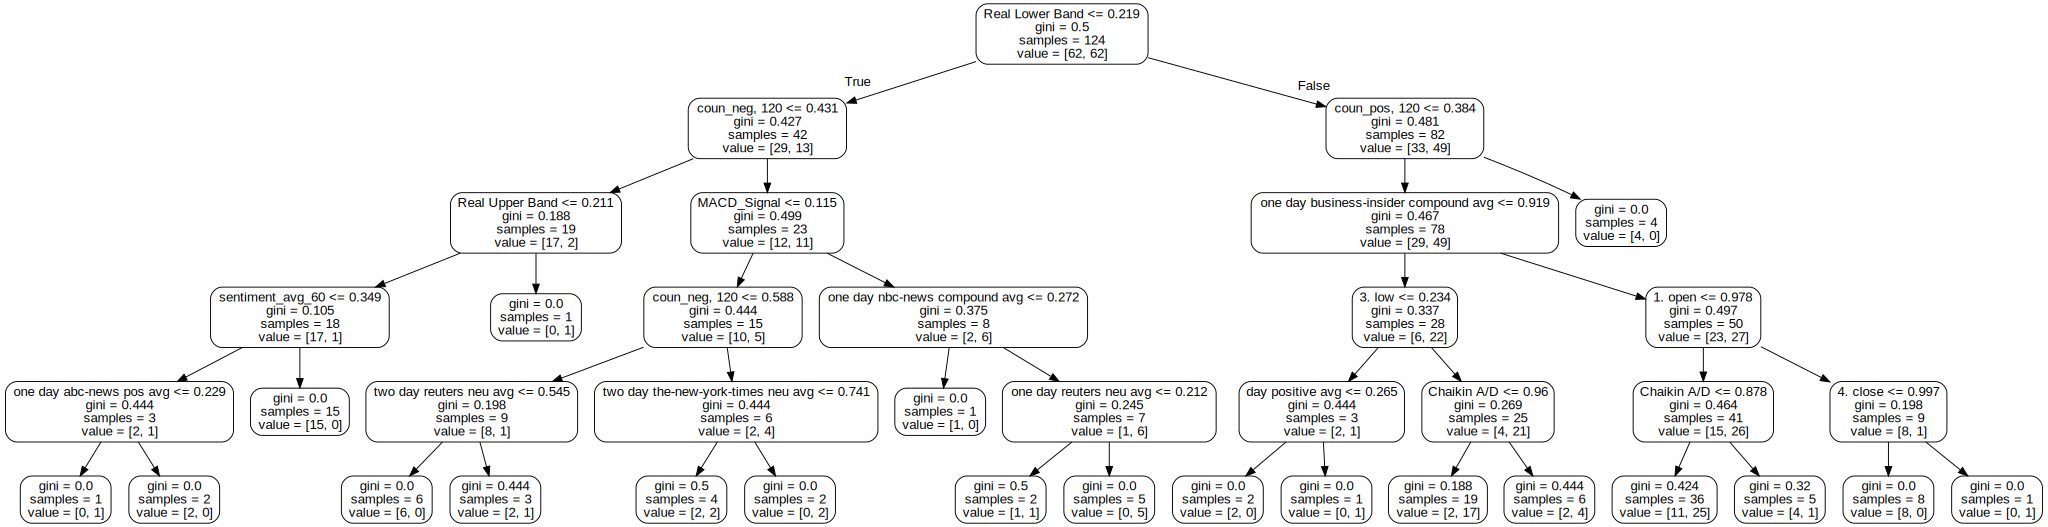

In [19]:
tree = forest.estimators_[1].fit(data_train, target_train)
export_graphviz(tree, out_file="mytree.dot", feature_names= X.columns , rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

#### Gradient boost

Train Set Score: 100.00%
test set score: 61.90%

 Top 10 Features:
('CCI', 0.3465)
('RSI', 0.1187)
('SlowD', 0.0932)
('ADX', 0.0517)
('1. open', 0.0469)
('coun_neu, 30', 0.0466)
('MACD_Hist', 0.0398)
('coun_pos, 30', 0.0371)
('5. volume', 0.0316)
('two day positive avg', 0.03)


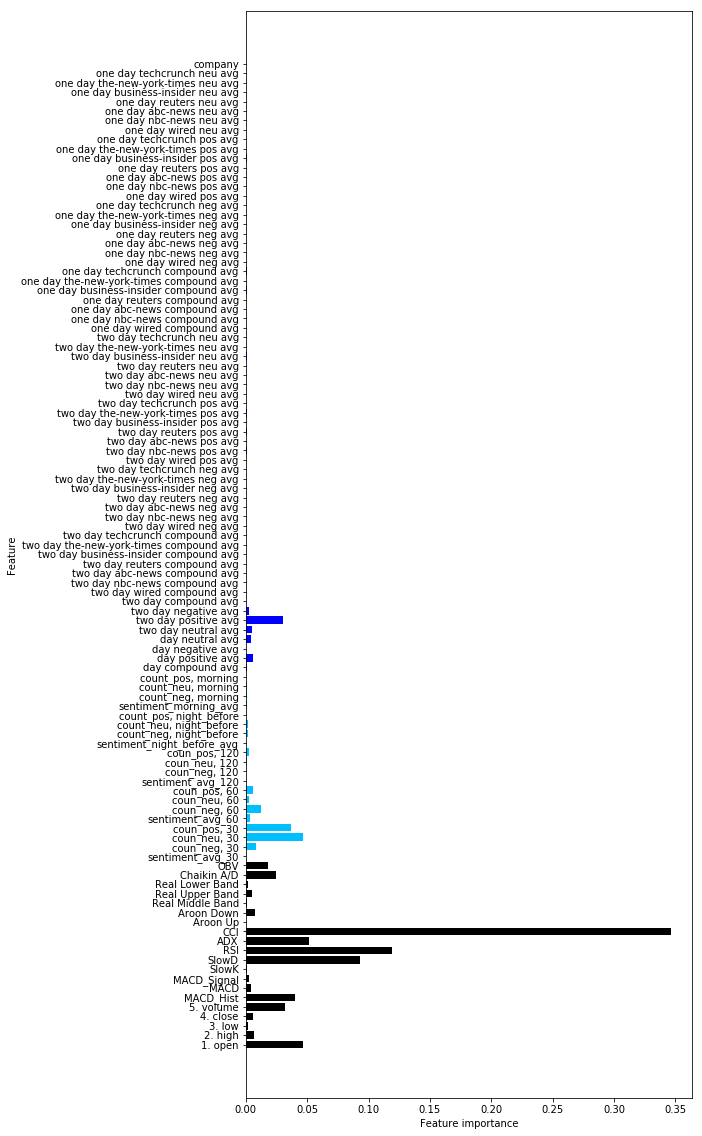

In [20]:
gradboost = GradientBoostingClassifier(random_state = 123, max_depth = 5, learning_rate = 0.01, n_estimators = 100)
gradboost.fit(data_train, target_train)
print('Train Set Score: {:0.2f}%'.format(gradboost.score(data_train, target_train) * 100))
print('test set score: {:0.2f}%'.format(gradboost.score(data_test, target_test)*100))
plot_feature_importances(gradboost, X)

feature_importances_grad = gradboost.feature_importances_
feature_importance_list_grad = [round(value, 4) for value in feature_importances_grad]
feature_importance_grad = dict(zip(X.columns, feature_importance_list_grad))
print('\n', 'Top 10 Features:')
sorted_dict_grad = sorted(feature_importance_grad.items(), key=lambda x: x[1], reverse=True)
for item in sorted_dict_grad[:10]:
    print(item)

#### Adaptive Boosting

Train Set Score: 100.00%
test set score: 73.81%

 Top 10 Features:
('SlowD', 0.14)
('RSI', 0.13)
('CCI', 0.12)
('1. open', 0.08)
('5. volume', 0.07)
('coun_neu, 30', 0.07)
('sentiment_avg_30', 0.04)
('two day compound avg', 0.04)
('ADX', 0.03)
('coun_pos, 30', 0.03)


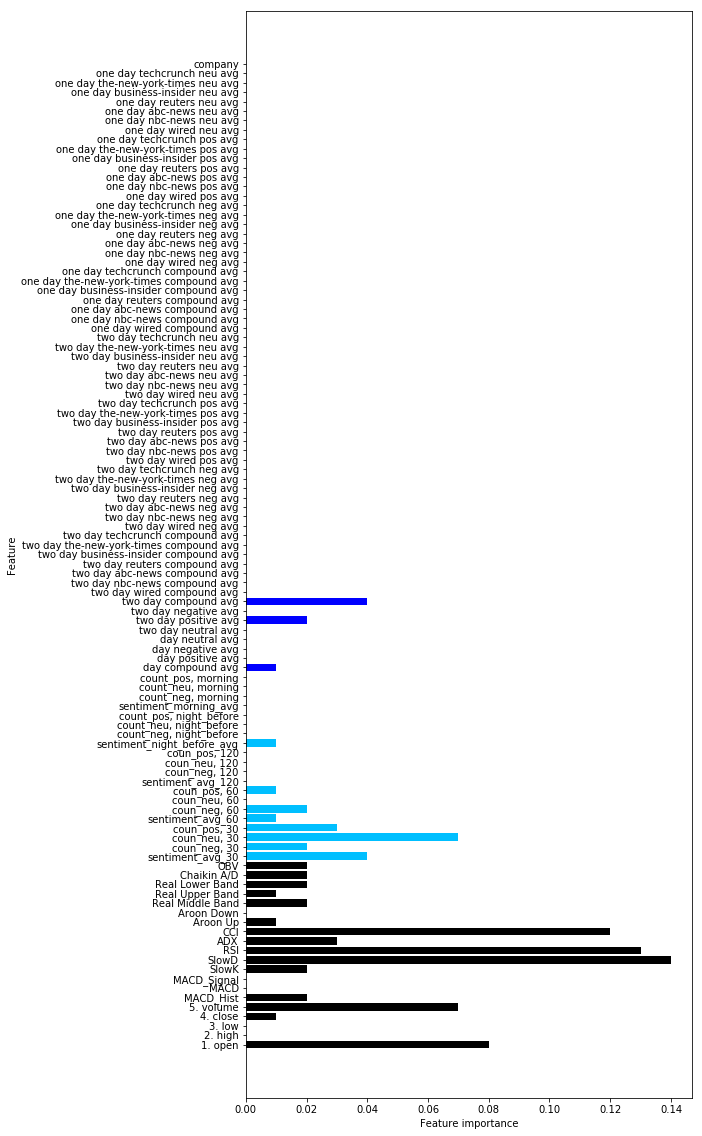

In [21]:
adaboost = AdaBoostClassifier(n_estimators=100)
adaboost.fit(data_train, target_train)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.005, n_estimators=100, random_state=None)
print('Train Set Score: {:0.2f}%'.format(adaboost.score(data_train, target_train) * 100))
print('test set score: {:0.2f}%'.format(adaboost.score(data_test, target_test)*100))
plot_feature_importances(adaboost, X)


feature_importances_ada = adaboost.feature_importances_
feature_importance_list_ada = [round(value, 4) for value in feature_importances_ada]
feature_importance_ada = dict(zip(X.columns, feature_importance_list_ada))
print('\n', 'Top 10 Features:')
sorted_dict_ada = sorted(feature_importance_ada.items(), key=lambda x: x[1], reverse=True)
for item in sorted_dict_ada[:10]:
    print(item)


#### Combinatoric Grid Searching - Adaboost

In [22]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

In [75]:
# Grid Search
ada_param_grid = {
    'learning_rate': [0.005, 0.01, 0.015],
    'n_estimators': [300, 500, 700, 1000],
}

In [76]:
dt_grid_search = GridSearchCV(adaboost, ada_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.005, 0.01, 0.015], 'n_estimators': [300, 500, 700, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [77]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(scaled_df, target)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 89.31%
Mean Testing Score: 68.59%
Best Parameter Combination Found During Grid Search:


{'learning_rate': 0.015, 'n_estimators': 700}

Train Set Score: 93.55%
Test set score: 71.43%


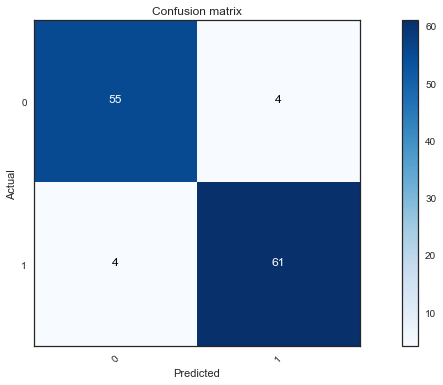

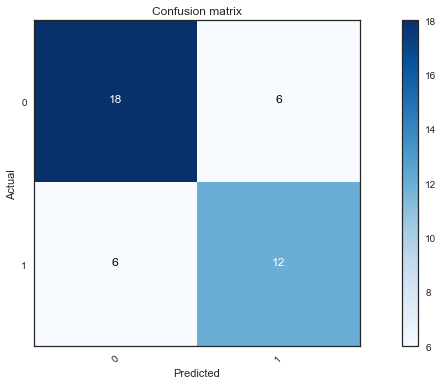

In [78]:
adaboost_best = AdaBoostClassifier(n_estimators=700, learning_rate = 0.015)
adaboost_best.fit(data_train, target_train)
print('Train Set Score: {:0.2f}%'.format(adaboost_best.score(data_train, target_train) * 100))
print('Test set score: {:0.2f}%'.format(adaboost_best.score(data_test, target_test)*100))

ada_predict_train = adaboost_best.predict(data_train)
ada_predict_test = adaboost_best.predict(data_test)
ada_matrix_train = confusion_matrix(ada_predict_train, target_train)
ada_matrix_test = confusion_matrix(ada_predict_test, target_test)
plot_confusion_matrix(ada_matrix_train, classes = set(y_resampled))
plot_confusion_matrix(ada_matrix_test, classes = set(y_resampled))

Train Set Score: 90.32%
Test set score: 66.67%


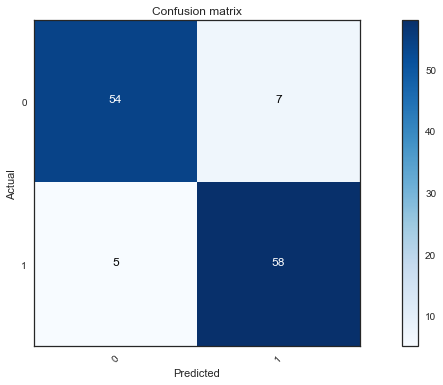

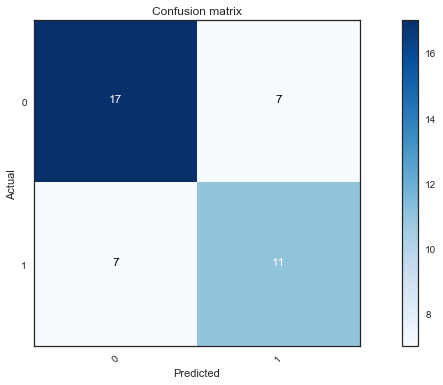

In [79]:
adaboost_best_tuned = AdaBoostClassifier(n_estimators=1000, learning_rate = 0.005)
adaboost_best_tuned.fit(data_train, target_train)
print('Train Set Score: {:0.2f}%'.format(adaboost_best_tuned.score(data_train, target_train) * 100))
print('Test set score: {:0.2f}%'.format(adaboost_best_tuned.score(data_test, target_test)*100))

ada_predict_train_tuned = adaboost_best_tuned.predict(data_train)
ada_predict_test_tunedd = adaboost_best_tuned.predict(data_test)
ada_matrix_train_tuned = confusion_matrix(ada_predict_train_tuned, target_train)
ada_matrix_test_tuned = confusion_matrix(ada_predict_test_tunedd, target_test)
plot_confusion_matrix(ada_matrix_train_tuned, classes = set(y_resampled))
plot_confusion_matrix(ada_matrix_test_tuned, classes = set(y_resampled))

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
data_train_ada, data_test_ada, target_train_ada, target_test_ada = train_test_split(X, target)
best_tuned_pred = adaboost_best_tuned.predict(X)
target_plot = pd.Series(target).to_frame()
tuned_pred_ada = pd.Series(best_tuned_pred).to_frame()
tuned_pred_ada.index = target_plot.index
pred_plot = pd.concat([df, tuned_pred_ada], axis =1)
price = pred_plot[['4. close', 'company', 0]]
price_fb = price[price['company'] == 1]
price_nf = price[price['company'] == 2]
price_ap = price[price['company'] == 3]
# plt.plot(pred_plot_24['up_down'], 'b.')
# plt.plot(pred_plot_24[0], 'r.')
# plt.show()

In [64]:
price_fb.index = pd.to_datetime(price_fb.index)
price_fb_24 = price_fb[price_fb.index.day == 24]
price_fb_25 = price_fb[price_fb.index.day == 25]
price_fb_26 = price_fb[price_fb.index.day == 26]
price_fb_27 = price_fb[price_fb.index.day == 27]
price_fb_28 = price_fb[price_fb.index.day == 28]
price_nf.index = pd.to_datetime(price_nf.index)
price_nf_24 = price_nf[price_nf.index.day == 24]
price_nf_25 = price_nf[price_nf.index.day == 25]
price_nf_26 = price_nf[price_nf.index.day == 26]
price_nf_27 = price_nf[price_nf.index.day == 27]
price_nf_28 = price_nf[price_nf.index.day == 28]
price_ap.index = pd.to_datetime(price_ap.index)
price_ap_24 = price_ap[price_ap.index.day == 24]
price_ap_25 = price_ap[price_ap.index.day == 25]
price_ap_26 = price_ap[price_ap.index.day == 26]
price_ap_27 = price_ap[price_ap.index.day == 27]
price_ap_28 = price_ap[price_ap.index.day == 28]

In [30]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.dates as mdates

# my func
x = np.linspace(0, 2 * np.pi, 100)
y = 3000 * np.sin(x)

# select how to color
cmap = ListedColormap(['r','b'])
norm = BoundaryNorm([2000,], cmap.N)

# get segments
xy = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.hstack([xy[:-1], xy[1:]])

# make line collection
lc = LineCollection(segments, cmap = cmap, norm = norm)
lc.set_array(y)

# plot
# fig, ax = plt.subplots()
# ax.add_collection(lc)
# ax.autoscale()
# plt.show()

In [ ]:
linecolors

In [68]:
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates

def pred_against_actual(df):
    inxval = mdates.date2num(df.index.to_pydatetime())
    points = np.array([inxval, df['4. close']]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)

    linecolors = []
    for i in range(0, len(df)):
        if df[0][i] == 0:
            color = 'red'
            linecolors.append(color)
        else:
            color = 'blue'
            linecolors.append(color) 

    cmap = ListedColormap(linecolors)
    fig, ax = plt.subplots()
    lc = LineCollection(segments, cmap = cmap)
    lc.set_array(inxval)
    ax.add_collection(lc)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    monthFmt = mdates.DateFormatter("%b")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.autoscale_view()
    plt.show()

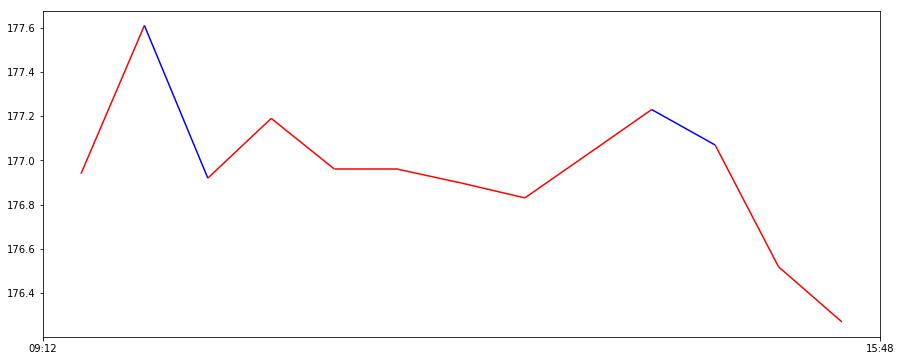

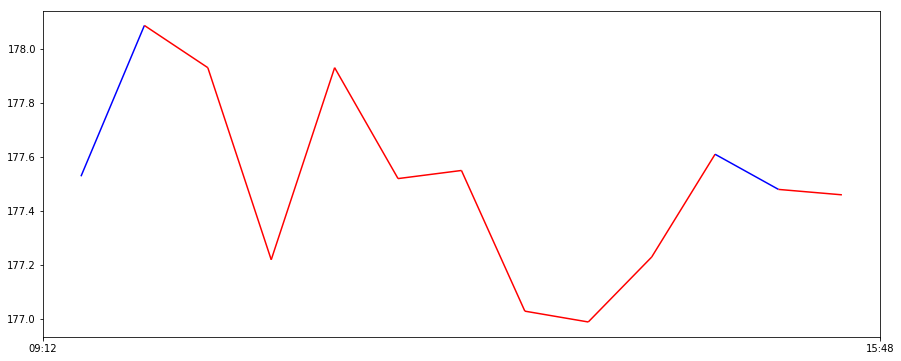

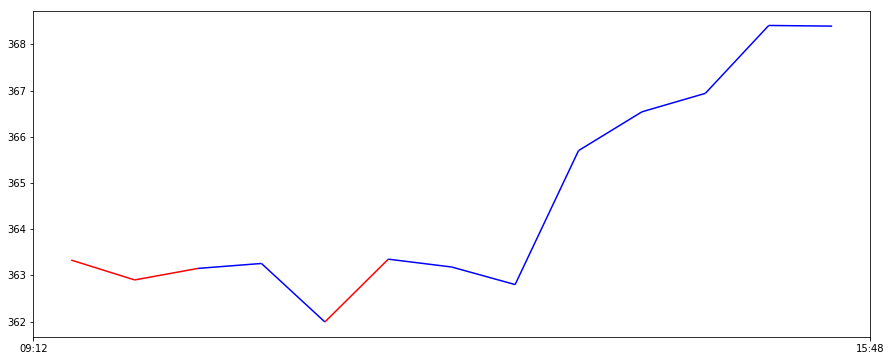

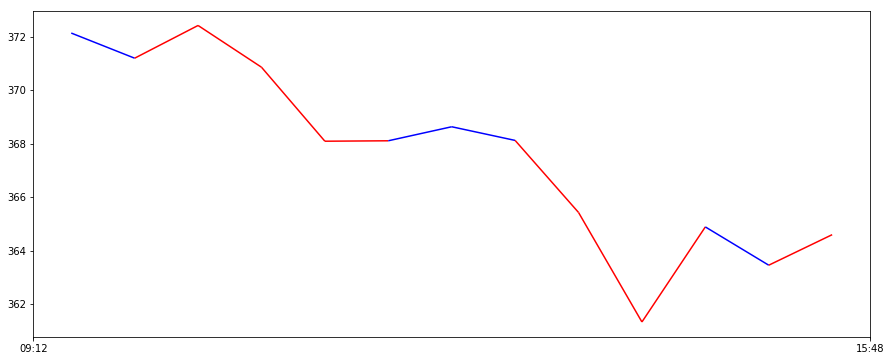

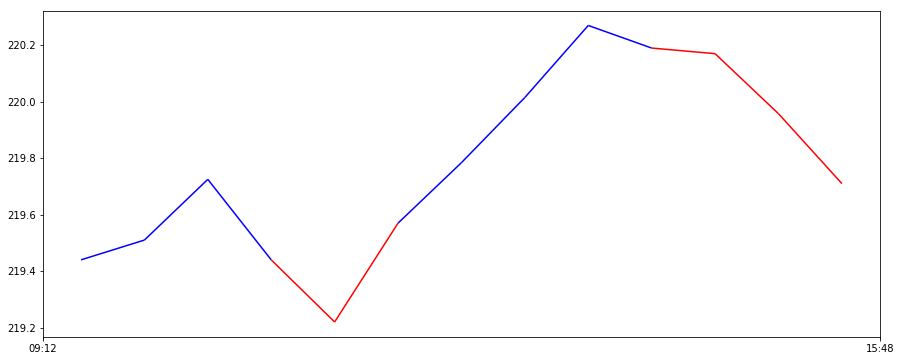

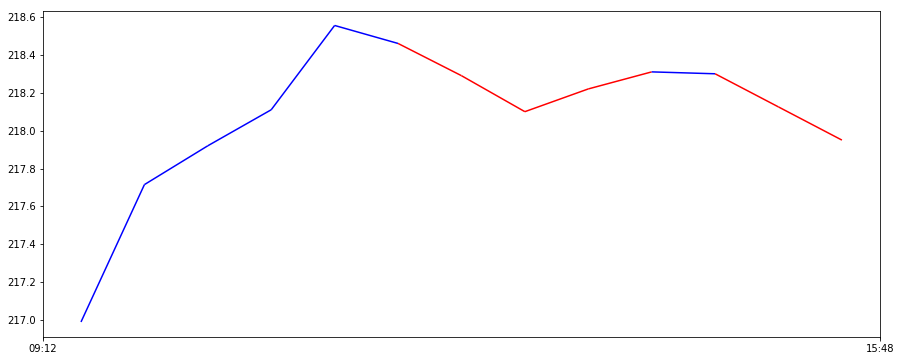

In [69]:
pred_against_actual(price_fb_28)
pred_against_actual(price_fb_27)
pred_against_actual(price_nf_28)
pred_against_actual(price_nf_27)
pred_against_actual(price_ap_28)
pred_against_actual(price_ap_27)

AUC for Adaboost: 0.7083333333333334


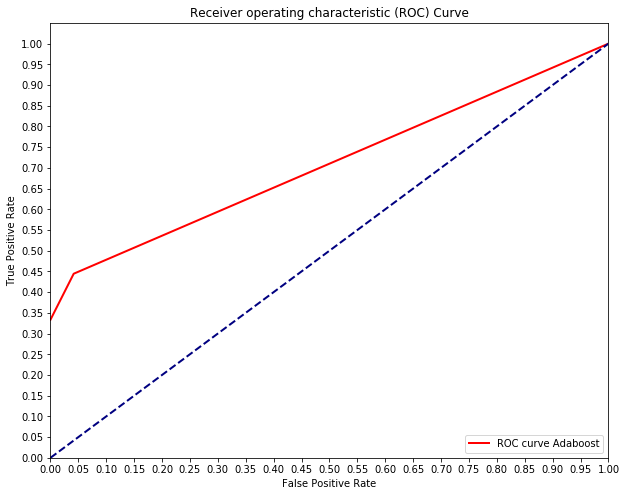

In [34]:
# Adaboost
plt.figure(figsize=(10,8))
area = []
# for n, pen in enumerate(penalties):
    #Fit a model
#Predict
y_hat_test = adaboost_best.predict(data_test)
y_score = adaboost_best.fit(data_train, target_train).decision_function(data_test)
fpr, tpr, thresholds = roc_curve(target_test, y_score)

print('AUC for {}: {}'.format('Adaboost', auc(fpr, tpr)))
lw = 2
plt.plot(fpr, tpr, color=colors[n],
         lw=lw, label='ROC curve {}'.format('Adaboost'))
area.append(auc(fpr, tpr))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [70]:
kfold_scores_adaboost = cross_val_score(adaboost_best, X_resampled, y_resampled, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (kfold_scores_adaboost.mean(), kfold_scores_adaboost.std() * 2))

Accuracy: 0.71 (+/- 0.10)


#### Tweets 

In [37]:
X_tweets = X.loc[:,'sentiment_avg_30':'count_pos, morning']

In [38]:
data_train_tweets, data_test_tweets, target_train_tweets, target_test_tweets = train_test_split(X_tweets, target)

Train Set Score: 83.76%
test set score: 69.23%


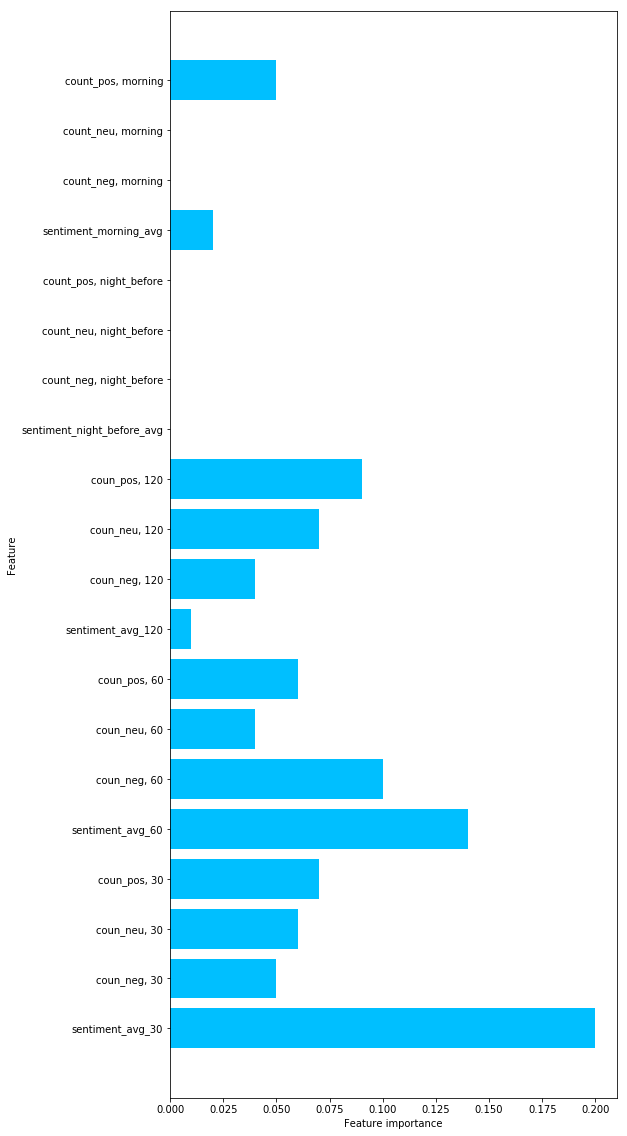

In [39]:
adaboost_tweets = AdaBoostClassifier(n_estimators=100)
adaboost_tweets.fit(data_train_tweets, target_train_tweets)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.005, n_estimators=100, random_state=None)
print('Train Set Score: {:0.2f}%'.format(adaboost_tweets.score(data_train_tweets, target_train_tweets) * 100))
print('test set score: {:0.2f}%'.format(adaboost_tweets.score(data_test_tweets, target_test_tweets)*100))
plot_feature_importances(adaboost_tweets, X_tweets)

In [40]:
tweeter_pos_count_two_hours = df['coun_pos, 120']

In [41]:
up_down = df.groupby(['coun_pos, 120'])['up_down'].count()

(array([52.,  1.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

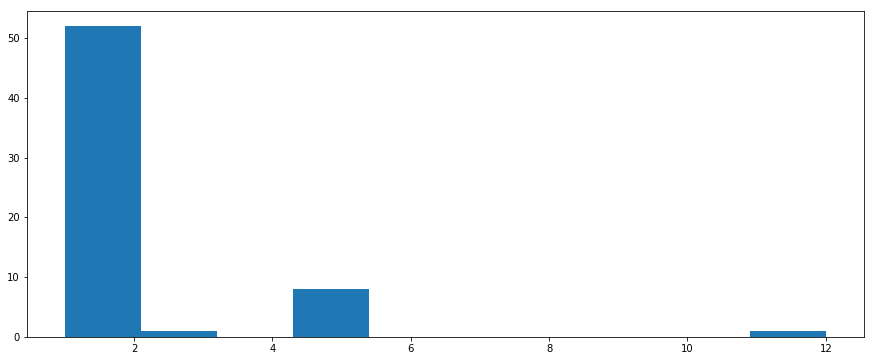

In [42]:
plt.hist(up_down)
# plt.bar(tweeter_pos_count_two_hours, (len(up_down) - sum(up_down)))

In [43]:
X_tweets_new = X_tweets
X_tweets_new["total_count_30"] = X_tweets_new['coun_neg, 30'] + X_tweets_new['coun_neu, 30'] + X_tweets_new['coun_pos, 30']
X_tweets_new["total_count_60"] = X_tweets_new['coun_neg, 60'] + X_tweets_new['coun_neu, 60'] + X_tweets_new['coun_pos, 60']
X_tweets_new["total_count_120"] = X_tweets_new['coun_neg, 120'] + X_tweets_new['coun_neu, 120'] + X_tweets_new['coun_pos, 120']
X_tweets_new["total_count_night_before"] = X_tweets_new['count_neg, night_before'] + X_tweets_new['count_neu, night_before'] + X_tweets_new['count_pos, night_before']
X_tweets_new["total_count_morning"] = X_tweets_new['count_neg, morning'] + X_tweets_new['count_neu, morning'] + X_tweets_new['count_pos, morning']

X_tweets_new = X_tweets_new.drop(['coun_neg, 30', 'coun_neu, 30', 'coun_pos, 30', 'coun_neg, 60', 'coun_neu, 60', 
                                  'coun_pos, 60', 'coun_neg, 120', 'coun_neu, 120', 'coun_pos, 120', 'count_neg, night_before', 
                                  'count_neu, night_before', 'count_pos, night_before','count_neg, morning','count_neu, morning', 'count_pos, morning'], axis =1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [44]:
X_tweets_new = X_tweets_new[['sentiment_avg_30', 'total_count_30', 'sentiment_avg_60','total_count_60', 'sentiment_avg_120', 'total_count_120', 'sentiment_night_before_avg', 'total_count_night_before', 'sentiment_morning_avg', 'total_count_morning']]

In [45]:
data_train_tweets_new, data_test_tweets_new, target_train_tweets_new, target_test_tweets_new = train_test_split(X_tweets_new, target)

Train Set Score: 87.18%
test set score: 64.10%


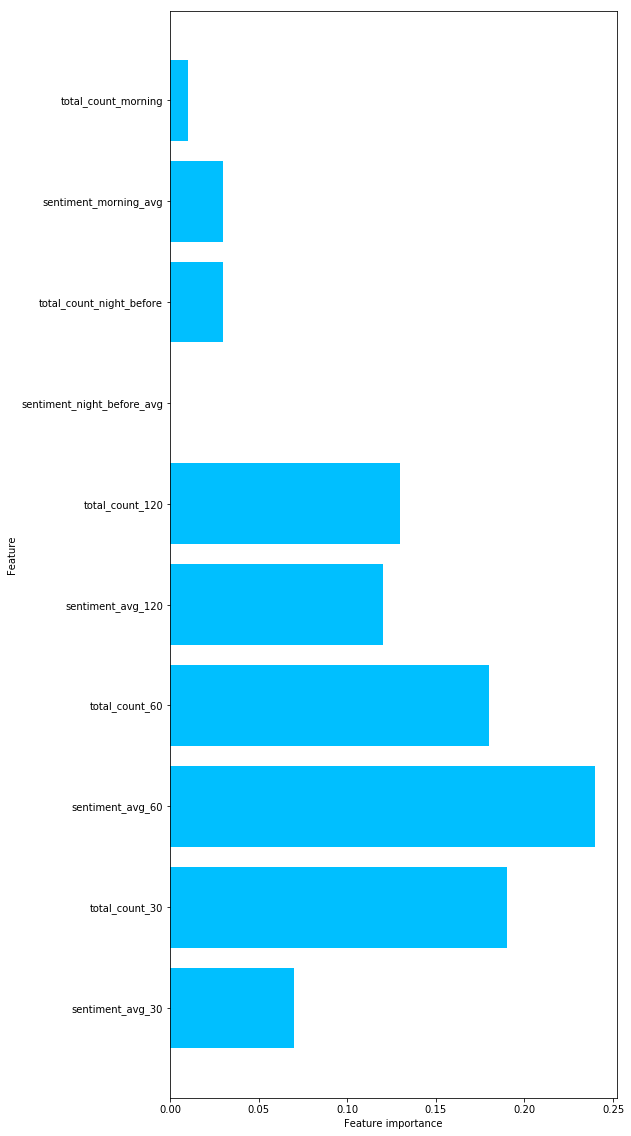

In [46]:
adaboost_tweets_new = AdaBoostClassifier(n_estimators=100)
adaboost_tweets_new.fit(data_train_tweets_new, target_train_tweets_new)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.005, n_estimators=100, random_state=None)
print('Train Set Score: {:0.2f}%'.format(adaboost_tweets_new.score(data_train_tweets_new, target_train_tweets_new) * 100))
print('test set score: {:0.2f}%'.format(adaboost_tweets_new.score(data_test_tweets_new, target_test_tweets_new)*100))
plot_feature_importances(adaboost_tweets_new, X_tweets_new)

#### Support Vector Machine

In [47]:
clf = svm.SVC(kernel='linear', C=1000000)
clf.fit(data_train, target_train) 
print('Train Set Score: {:0.2f}%'.format(clf.score(data_train, target_train) * 100))
print('test set score: {:0.2f}%'.format(clf.score(data_test, target_test)*100))

Train Set Score: 100.00%
test set score: 73.81%


In [48]:
# Grid Search
svm_grid = {
    'C': [100, 10000, 100000, 1000000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}
svm_grid_search = GridSearchCV(svm.SVC(), svm_grid, return_train_score=True)
svm_grid_search.fit(data_train, target_train)

svm_gs_training_score = np.mean(svm_grid_search.cv_results_['mean_train_score'])
svm_gs_testing_score = svm_grid_search.score(scaled_df, target)

print("Mean Training Score: {:.4}%".format(svm_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(svm_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
svm_grid_search.best_params_

Mean Training Score: 94.99%
Mean Testing Score: 60.9%
Best Parameter Combination Found During Grid Search:


{'C': 10000, 'kernel': 'sigmoid'}

In [49]:
clf_best = svm.SVC(kernel='sigmoid', C=10000)
clf_best.fit(data_train, target_train) 

scores_svm = cross_val_score(clf_best, X, target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))

Accuracy: 0.58 (+/- 0.24)


AUC for SVM: 0.7731481481481481


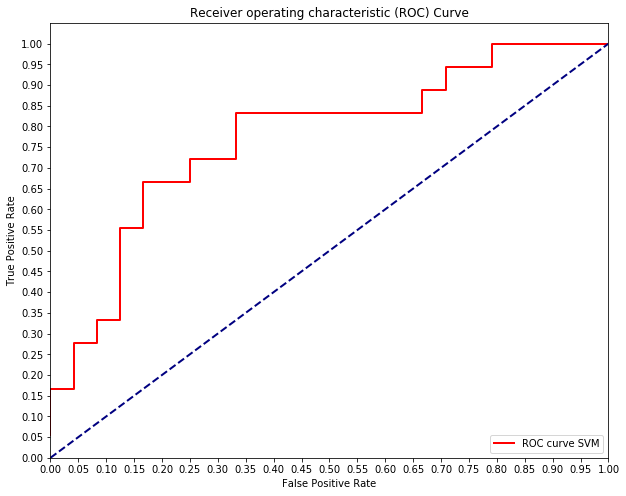

In [50]:
# SVM
# penalties = ['l1', 'l2']
# colors = ['r', 'orange']

plt.figure(figsize=(10,8))
area = []
# for n, pen in enumerate(penalties):
    #Fit a model
#Predict
y_hat_test = clf.predict(data_test)
y_score = clf.fit(data_train, target_train).decision_function(data_test)
fpr, tpr, thresholds = roc_curve(target_test, y_score)

print('AUC for {}: {}'.format('SVM', auc(fpr, tpr)))
lw = 2
plt.plot(fpr, tpr, color=colors[n],
         lw=lw, label='ROC curve {}'.format('SVM'))
area.append(auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()